<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/Detec%C3%A7%C3%A3o_Histopatol%C3%B3gica_de_C%C3%A2ncer_PCam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção Histopatológica de Câncer Utilizando Aprendizado por Transferência

![](https://raw.githubusercontent.com/basveeling/pcam/master/pcam.jpg)

<blockquote>

## Universidade Federal de Goiás

### Alunos:

* Gustavo 

* Iago

* Pedro



</blockquote>


####Fonte dos Dados Utilizados:
<blockquote>

[Detecção Histopatológica de Câncer - Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/data)

[PatchCamelyon (PCam) Dataset](https://github.com/basveeling/pcam)

</blockquote>
<hr>

## Importação de Bibliotecas e Download dos Dados

In [2]:
import pandas as pd
import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import cv2
import os
import shutil


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.metrics import plot_roc_curve

tf.random.set_seed(42)  #torna os números aleatórios gerados previsíveis, 
seed(42)    #de modo a ter consistência entre execuções. 42 escolhido arbitrariamente.


# Constantes
TAMANHO_IMAGEM = 96
CANAIS_IMAGEM = 3
TAMANHO_AMOSTRA = 5000

BATCH_SIZE_TREINO = 50
BATCH_SIZE_TESTE = 50

DATASET_PATH = "/content/dataset/"

# Muda o estilo de figuras que serão criadas no notebook
sns.set_theme(style='white', palette='deep')

>Os códigos da célula abaixo são necessários para o download do dataset do Kaggle. Para a correta execução, é necessário que seja gerado o arquivo ```kaggle.json```, que contém a autorização para uso da API. Mais informações podem ser obtidas na documentação da [API do Kaggle](https://www.kaggle.com/docs/api).

In [3]:
# Atualiza API do Kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle 

!mkdir -p ~/.kaggle                 # Cria o diretório para o arquivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json    # Muda as permissões do arquivo
!cp kaggle.json ~/.kaggle/          # Copia o arquivo kaggle.json para o diretório recém criado

# Download do arquivo zip para o caminho definido
!kaggle competitions download -c histopathologic-cancer-detection -p {DATASET_PATH}

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=4dff4a5b66a939350e139499a9f5c7e6a02a8b8c656e5e58bd237bc017508e0d
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
100% 6.30G/6.31G [01:33<00:00, 37.9MB/s]
100% 6.31G/6.31G [01:33<00:00, 72.5MB/s]


In [4]:
# Unzip do arquivo
!unzip -q {DATASET_PATH}histopathologic-cancer-detection.zip -d {DATASET_PATH}

## Criação de DataFrames

> O arquivo ```train_labels.csv``` contém o nome das imagens (armazenadas em duas pastas distintas, uma para treino e outra para teste) e o seu respectivo label.

In [5]:
df_dados = pd.read_csv(f'{DATASET_PATH}train_labels.csv')   # Cria um DataFrame
print(df_dados.shape)                                       # Formato (Linhas, Colunas)
df_dados.head(3)                                            # 3 primeiras linhas

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [6]:
# Checa a quantidade de imagens em cada diretório
print("Quantidade de Amostras de Treino:",
      len(os.listdir('/content/dataset/train')))

print("Quantidade de Amostras de Teste:",
      len(os.listdir('/content/dataset/test')))

Quantidade de Amostras de Treino: 220025
Quantidade de Amostras de Teste: 57458


> Plot para Visualização da Distribuição de Amostras para cada um dos labels

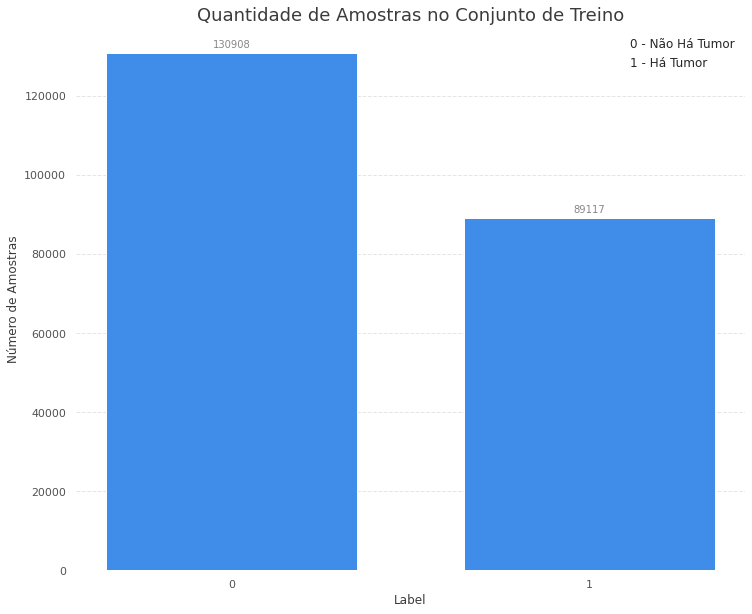

In [8]:
#@title Distribuição de amostras entre classes (original)
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Quantidade de Amostras no Conjunto de Treino", size=18, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
plt.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',
           prop={'size':12},
           )

plt.show();

In [20]:
# Iguala a quantidade de amostras com label 0 e amostras com label 1

df_0 = df_dados[df_dados['label'] == 0].sample(TAMANHO_AMOSTRA,
                                               random_state = 42)    # Apenas imagens com label 0
df_1 = df_dados[df_dados['label'] == 1].sample(TAMANHO_AMOSTRA,
                                               random_state = 42)    # Apenas imagens com label 1

# Concatena os dataframes e embaralha (shuffle) as imagens
df_dados = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_dados = shuffle(df_dados)

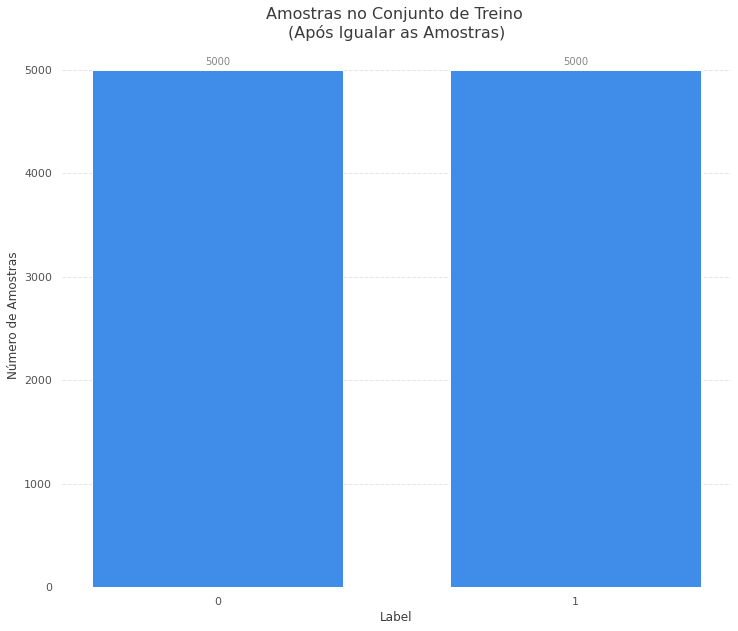

In [19]:
#@markdown Distribuição após igualar a quantidade de amostras por classe
#@markdown
#@markdown _duplo clique para exibir o código_

count_label = df_dados['label'].value_counts() # conta a quantidade de amostras 0 e amostras 1

def autolabel(rects):
    """
    Essa é uma função auxiliar cujo único objetivo é anexar, ao topo de cada uma das barras do gráfico,
    o valor que ela representa.
    """
    for rect in rects:
        height = rect.get_height()  # Capta a altura da barra
        ax.annotate('{}'.format(height),    # Anota a altura
                    xy=(rect.get_x() + rect.get_width() / 2, height),   # Nessa posição (No "meio" da barra, na altura extraída)
                    xytext=(0, 3),  # Define um offset no valor de y
                    textcoords="offset points", # Estabelece que o offset deve ser seguido (para o texto ser anotado um pouco acima da altura da barra)
                    fontsize = 10,  # Tamanho da fonte
                    alpha=0.95, # Transparência da fonte
                    color='gray',   # Cor da fonte
                    ha='center',    # Alinhamento horizontal central
                    va='bottom',    # Alinhamento vertical inferior
                    )

fig = plt.figure(figsize=(12, 10))  # Cria a figura
ax = plt.gca()  # Criando uma variável ax com base no método "get current axes"

rects1 = plt.bar(x=list(count_label.index), height= list(count_label.values),   # Cria o plot. X = Labels, Y/Altura = Número de amostras.
                 width=0.7, # Largura das barras
                 color='#3f8de8')   # Cor do plot (azul)

autolabel(rects1)   # Chama a função criada anteriormente

plt.box(False)  # Desabilita as linhas envolvendo o plot

plt.grid(axis='y', alpha=0.5, ls="--")  # Exibe tracejados no eixo y

plt.title("Amostras no Conjunto de Treino \n(Após Igualar as Amostras)", size=16, alpha=0.9)   # Título da imagem
plt.ylabel("Número de Amostras", alpha=0.9) # Nome do eixo y
plt.xlabel("Label", alpha=0.9)      # Nome do eixo x
plt.xticks([0, 1], alpha=0.8)   # Definindo quais são os pontos a serem marcados no eixo x
plt.yticks(alpha=0.8)       # Define a transparência do texto no eixo y

# Cria uma legenda personalizada
patch_legenda0 = mpatches.Patch(color='none', label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none', label='1 - Há Tumor')
#plt.legend(handles=[patch_legenda0, patch_legenda1],
#           edgecolor='white',
#           framealpha = 0,
#           prop={'size':12},
#           )

plt.show();

In [24]:
(df.groupby([nome_coluna])[nome_coluna].nunique()).index

Int64Index([0, 1], dtype='int64', name='label')

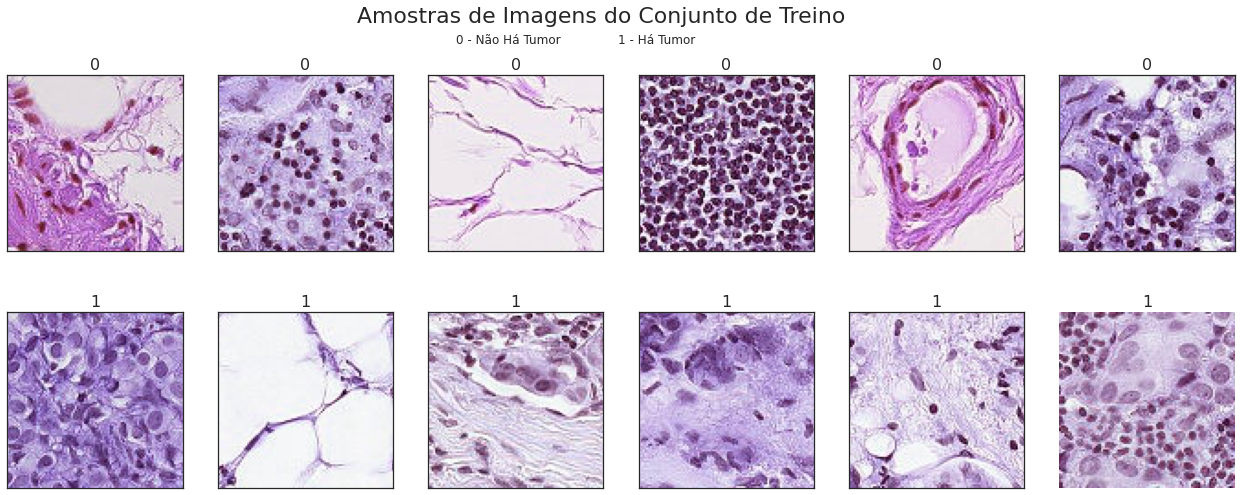

In [25]:
#@title Exemplo de Imagens
#@markdown A seleção de imagens a serem exibidas é aleatória
#@markdown
#@markdown _duplo clique exibe o código_

# Constantes que serão usadas nessa célula
nome_coluna = 'label'
figure_cols = 6
df = df_dados
IMAGE_PATH = '/content/dataset/train/' 

# Cria uma variável index com os valores dos labels e o nome da coluna
categories = (df.groupby([nome_coluna])[nome_coluna].nunique()).index

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    sample = df[df[nome_coluna]==cat].sample(figure_cols)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'     # Gera o caminho da imagem
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y

# Cria labels (do matplotlib) para serem exibidos na legenda da imagem
patch_legenda0 = mpatches.Patch(color='none',   
                                label='0 - Não Há Tumor')
patch_legenda1 = mpatches.Patch(color='none',
                                label='1 - Há Tumor')

# Adiciona uma legenda na imagem, com base nos labels anteriores
f.legend(handles=[patch_legenda0, patch_legenda1],
           edgecolor='white',                   # Cor da borda
           prop={'size':12},                    # Tamanho da fonte
           ncol=2,                              # Número de colunas
           bbox_to_anchor=(0.26, .76, 1, 1),    #(x, y, width, height)
           loc=3,                               # Posição
           )
f.suptitle("Amostras de Imagens do Conjunto de Treino",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Treino.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

## Criando DataFrames de Validação e Treino

In [26]:
print(df_dados.shape)
df_dados.head()

(10000, 2)


,id,label
6366,5f55e964a99153d1e3479f48a4da0d382c65033f,1
9628,300965900389e1d01e3bd8544adf3bc42a7999a6,1
5916,aed33920dac44b9cc403939d880fe66922e4038e,1
681,cf64d0b38e5c21d8ec838389a88f88b83bd311f7,0
5459,5e7ce06aa63e0953f160e93f02869ee87a6bfdf7,1


In [12]:
df_dados['label'].value_counts()

1    5000
0    5000
Name: label, dtype: int64

In [13]:
y = df_dados['label']

df_treino, df_val = train_test_split(df_dados, test_size=0.20,
                                    random_state=42,
                                    stratify=y) # Cria uma divisão balanceada

print(df_treino.shape)
print(df_val.shape)

(8000, 2)
(2000, 2)


In [15]:
df_treino['label'].value_counts()

1    4000
0    4000
Name: label, dtype: int64

In [17]:
df_val['label'].value_counts()

1    1000
0    1000
Name: label, dtype: int64

## Estrutura de Diretórios para Utilização do Keras DataGenerator

In [ ]:
# Create a new directory
dir_base = 'dir_base'
os.mkdir(dir_base)

# now we create 2 folders inside 'dir_base':

# dir_treino
    # a_sem_tumor
    # b_com_tumor

# dir_val
    # a_sem_tumor
    # b_com_tumor



# create a path to 'dir_base' to which we will join the names of the new folders
# dir_treino
dir_treino = os.path.join(dir_base, 'dir_treino')
os.mkdir(dir_treino)

# dir_val
dir_val = os.path.join(dir_base, 'dir_val')
os.mkdir(dir_val)



# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside dir_treino
no_tumor_tissue = os.path.join(dir_treino, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_treino, 'b_com_tumor')
os.mkdir(has_tumor_tissue)


# create new folders inside dir_val
no_tumor_tissue = os.path.join(dir_val, 'a_sem_tumor')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(dir_val, 'b_com_tumor')
os.mkdir(has_tumor_tissue)

In [19]:
os.listdir('dir_base/dir_treino')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

### Transferindo Imagens

In [20]:
# Set the id as the index in df_dados
df_dados.set_index('id', inplace=True)

In [27]:
# Get a list of train and val images
list_treino = list(df_treino['id'])
list_val = list(df_val['id'])



# Transfer the train images

for image in list_treino:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_dados.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    
    # source path to image
    src = os.path.join('/content/dataset/train', fname)
    # destination path to image
    dst = os.path.join(dir_treino, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in list_val:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_dados.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_sem_tumor'
    if target == 1:
        label = 'b_com_tumor'
    

    # source path to image
    src = os.path.join('/content/dataset/train', fname)
    # destination path to image
    dst = os.path.join(dir_val, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [29]:
print(len(os.listdir('dir_base/dir_treino/a_sem_tumor')))
print(len(os.listdir('dir_base/dir_treino/b_com_tumor')))
print()
print(len(os.listdir('dir_base/dir_val/a_sem_tumor')))
print(len(os.listdir('dir_base/dir_val/b_com_tumor')))

4000
4000

1000
1000


## Criando Geradores (Keras)

In [70]:
train_path = 'dir_base/dir_treino'
valid_path = 'dir_base/dir_val'
test_path = '/content/dataset/test'

num_amostras_treino = len(df_treino)
num_amostras_val = len(df_val)

passos_treino = np.ceil(num_amostras_treino / BATCH_SIZE_TREINO)
passos_val = np.ceil(num_amostras_val / BATCH_SIZE_TESTE)

In [71]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                                        batch_size=BATCH_SIZE_TREINO,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                                        batch_size=BATCH_SIZE_TESTE,
                                        class_mode='categorical')

test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Criação do Modelo

In [73]:
conv_base = MobileNetV2(weights='imagenet',
                           include_top=False,
                           input_shape=(96,96,3))
conv_base.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [74]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.3))
model.add(Dense(2, activation='softmax'))

In [75]:
print('Quantidade de pesos treináveis antes do congelamento da base convolucional:', len(model.trainable_weights))
conv_base.trainable = False
print('Quantidade de pesos treináveis após o congelamento da base convolucional:', len(model.trainable_weights))

Quantidade de pesos treináveis antes do congelamento da base convolucional: 160
Quantidade de pesos treináveis após o congelamento da base convolucional: 4


In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 11520)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2949376   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
Total params: 5,207,874
Trainable params: 2,949,890
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
model.compile(Adam(lr=0.001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [78]:
print(train_gen.class_indices)
print(val_gen.class_indices)

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}
{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}


In [79]:
filepath = "content/model.h5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                              verbose=1, mode='max', min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [80]:
history = model.fit(train_gen, steps_per_epoch=passos_treino, 
                              validation_data=val_gen,
                              validation_steps=passos_val,
                              epochs=20, verbose=1,
                              callbacks=[reduce_lr, checkpoint, early_stop])

Epoch 1/20
160/160 [==============================] - 83s 497ms/step - loss: 0.8571 - accuracy: 0.7919 - val_loss: 0.3431 - val_accuracy: 0.8435

Epoch 00001: val_accuracy improved from -inf to 0.84350, saving model to content/model.h5
Epoch 2/20
160/160 [==============================] - 79s 493ms/step - loss: 0.3239 - accuracy: 0.8516 - val_loss: 0.3367 - val_accuracy: 0.8465

Epoch 00002: val_accuracy improved from 0.84350 to 0.84650, saving model to content/model.h5
Epoch 3/20
160/160 [==============================] - 78s 490ms/step - loss: 0.2757 - accuracy: 0.8833 - val_loss: 0.3300 - val_accuracy: 0.8630

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00003: val_accuracy improved from 0.84650 to 0.86300, saving model to content/model.h5
Epoch 4/20
160/160 [==============================] - 79s 495ms/step - loss: 0.2156 - accuracy: 0.9103 - val_loss: 0.3350 - val_accuracy: 0.8615

Epoch 00004: val_accuracy did not improve from 0.86300
Epoc

Métricas a serem implementadas:

https://keras.io/api/metrics/classification_metrics/#recall-class

https://keras.io/api/metrics/classification_metrics/#auc-class